# Fraud Detection with Synthetic Financial Dataset

## Business Problem 

Fraud has quickly become a multi-billion dollar problem for the banking and finance industry. A report by The Association of Certified Fraud Examiners (ACFE, 2018) suggest that banks are losing up to 5% of their revenue to fraud alone. 

## Data Question 

1) How can we identify fraudulent transactions using the dataset? 

2) Using various machine learning algorithms to find the one with the highest accuracy for fraud prediction, and more importantly can fraudulent transaction be predicted?

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, f1_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from collections import Counter

Data source: https://www.kaggle.com/ealaxi/paysim1

In [44]:
#Load csv file as dataframe
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

### Fields of Dataset 

***

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

***

In [4]:
#Check on the first five records
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [45]:
#Convert all the column names to lower case
df.columns = df.columns.str.lower()

In [6]:
#Check on the first five records after column name conversion
df.head()

,step,type,amount,nameorig,oldbalanceorg,newbalanceorig,namedest,oldbalancedest,newbalancedest,isfraud,isflaggedfraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**Observation:** From the first five records, we could see that the oldbalancedest and newbalancedest does not sum up to what it is supposed to be after a payment or transfer. We will explore and check on this below.

In [46]:
#Rename columns to make it more intuitive to understand
df.rename(columns={'nameorig': 'name_origin'
                 , 'oldbalanceorg': 'old_balance_origin'
                 , 'newbalanceorig': 'new_balance_origin'
                 , 'namedest': 'name_destination'
                 , 'oldbalancedest': 'old_balance_destination'
                 , 'newbalancedest': 'new_balance_destination'}, inplace = True)

In [8]:
#Check on no. of entries and columns, as well as data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   step                     int64  
 1   type                     object 
 2   amount                   float64
 3   name_origin              object 
 4   old_balance_origin       float64
 5   new_balance_origin       float64
 6   name_destination         object 
 7   old_balance_destination  float64
 8   new_balance_destination  float64
 9   isfraud                  int64  
 10  isflaggedfraud           int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [9]:
#Check for null values in dataframe
df.isnull().sum()

step                       0
type                       0
amount                     0
name_origin                0
old_balance_origin         0
new_balance_origin         0
name_destination           0
old_balance_destination    0
new_balance_destination    0
isfraud                    0
isflaggedfraud             0
dtype: int64

In [10]:
#Check for duplicated rows
df.duplicated().sum()

0

In [11]:
#Check the statistics of the dataset
df.describe()

,step,amount,old_balance_origin,new_balance_origin,old_balance_destination,new_balance_destination,isfraud,isflaggedfraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


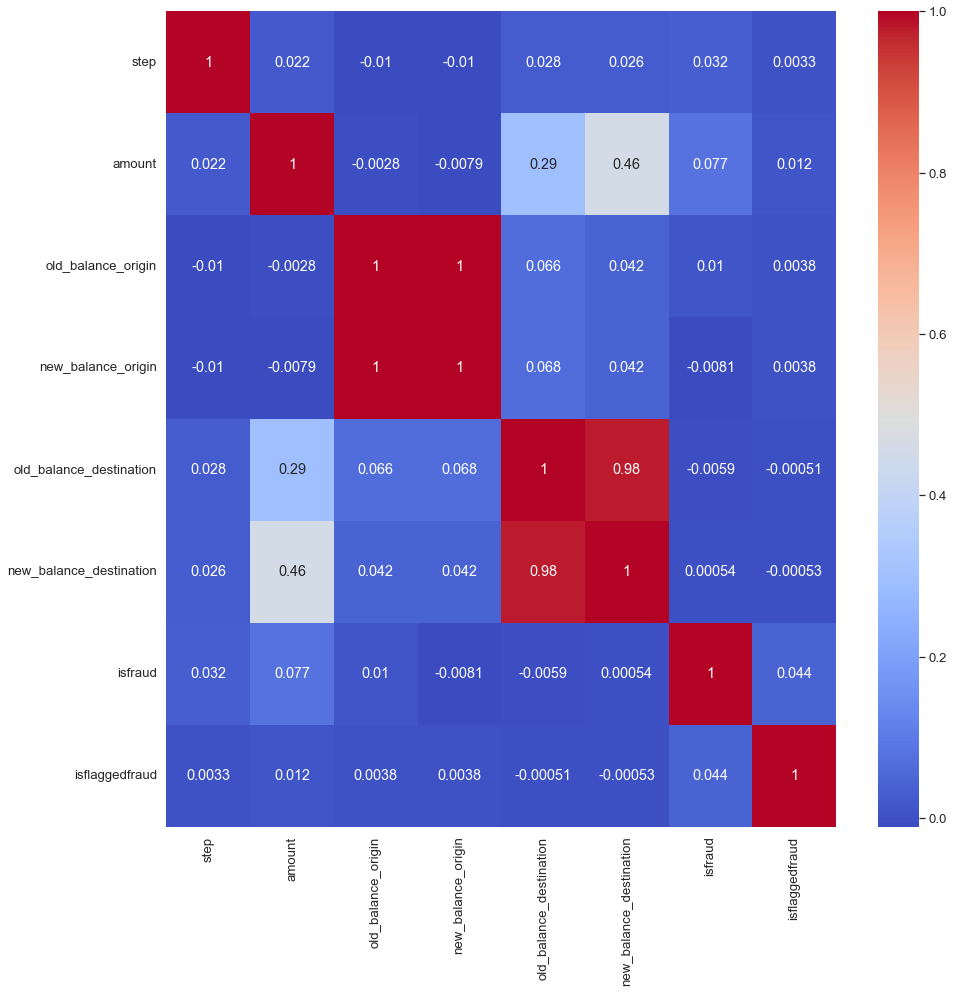

In [47]:
#Plot correlation of fields using heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap = "coolwarm", annot=True)
plt.show()

## Exploratory Data Analysis 

In [12]:
#Check for the distribution of fraud count
df.isfraud.value_counts()

0    6354407
1       8213
Name: isfraud, dtype: int64

In [ ]:
plt.figure(figsize =(10, 7))
plt.pie(df['isfraud'])
  
# show plot
plt.show()

Data is largely imbalanced as per expectation.

In [13]:
#Check distribution of transaction type count when "isfraud" equals to 1
df[df['isfraud']==1].type.value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

Fraudulant transactions seem to be happening on two specific types of transactions, CASH_OUT and TRANSFER.

In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by **transferring** to another account and then **cashing out** of the system.

**Observation:** The dataset is in line with what the fraudulent agents have done.

### isflaggedfraud field 

In [14]:
#Check the type of transaction that has "isflaggedfraud" flagged as 1
df[df['isflaggedfraud']==1].type.value_counts()

TRANSFER    16
Name: type, dtype: int64

In [15]:
#Check the minimum amount of transfer when "isflaggedfraud" equals to 1
df[df['isflaggedfraud']==1].amount.min()

353874.22

In [16]:
#Check if there are any records with fraudulent Transfer transaction type and amount more than 200,000 not flagged in isflaggedfraud field
df[(df['isflaggedfraud']==0) & (df['type']=='TRANSFER') & (df['amount'] > 200000) & (df['isfraud'] == 1)]

,step,type,amount,name_origin,old_balance_origin,new_balance_origin,name_destination,old_balance_destination,new_balance_destination,isfraud,isflaggedfraud
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.0,0.0,1,0
2301,1,TRANSFER,235238.66,C1872047468,235238.66,0.00,C116289363,0.0,0.0,1,0
3059,2,TRANSFER,1096187.24,C1093223281,1096187.24,0.00,C2063275841,0.0,0.0,1,0
3162,2,TRANSFER,963532.14,C1440057381,963532.14,0.00,C268086000,0.0,0.0,1,0
4440,4,TRANSFER,10000000.00,C7162498,12930418.44,2930418.44,C945327594,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362608,742,TRANSFER,258355.42,C1226129332,258355.42,0.00,C1744173808,0.0,0.0,1,0
6362612,743,TRANSFER,1258818.82,C1531301470,1258818.82,0.00,C1470998563,0.0,0.0,1,0
6362614,743,TRANSFER,339682.13,C2013999242,339682.13,0.00,C1850423904,0.0,0.0,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.0,0.0,1,0


**Observation:** 
isflaggedfraud field is not marked as 1 for over 2700  of fraudulent transfer transactions that are with more than 200,000 monetary value.

In [17]:
#Check correctly classified cases as per column description
df[(df['isflaggedfraud']==1) & (df['type']=='TRANSFER') & (df['amount'] > 200000) & (df['isfraud'] == 1)]

,step,type,amount,name_origin,old_balance_origin,new_balance_origin,name_destination,old_balance_destination,new_balance_destination,isfraud,isflaggedfraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


There are 16 transactions that are flagged correctly and 2724 transactions that are supposed to be flagged but not flagged. Since the number of correctly flagged records is relatively small, this feature will probably not be useful in our prediction of fraudulent cases. We will be dropping this feature.

In [18]:
#Drop "isflaggedfraud" column
df.drop(columns = 'isflaggedfraud', inplace = True)

### Check on relationship between origin and destination accounts

Taking reference from this description of the dataset: Agents aims to profit by taking control or customers accounts and try to empty the funds by **transferring** to another account and then **cashing out** of the system.

In [19]:
#Take a subset of original dataset where transfer transaction is fraudulent 
transfer_fraud = df[(df['isfraud']==1) & (df['type']=='TRANSFER')]

In [20]:
#Take a subset of original dataset where cash out transaction is fraudulent 
cashout_fraud = df[(df['isfraud']==1) & (df['type']=='CASH_OUT')]

In [21]:
#Check if the destination account of the fraudulent transfer transaction is used for cash out transaction
transfer_fraud.name_destination.isin(cashout_fraud.name_origin).any()

False

**Observation:** Since the destination account of the fraudulent transaction is not used for cash out transaction, these features will not be useful in predicting fraudulent transactions. 

In [22]:
#Drop "name_origin" and "name_destination" columns
df.drop(columns = ['name_origin', 'name_destination'], inplace = True)

###  Check the distribution of step against fraudulent transaction

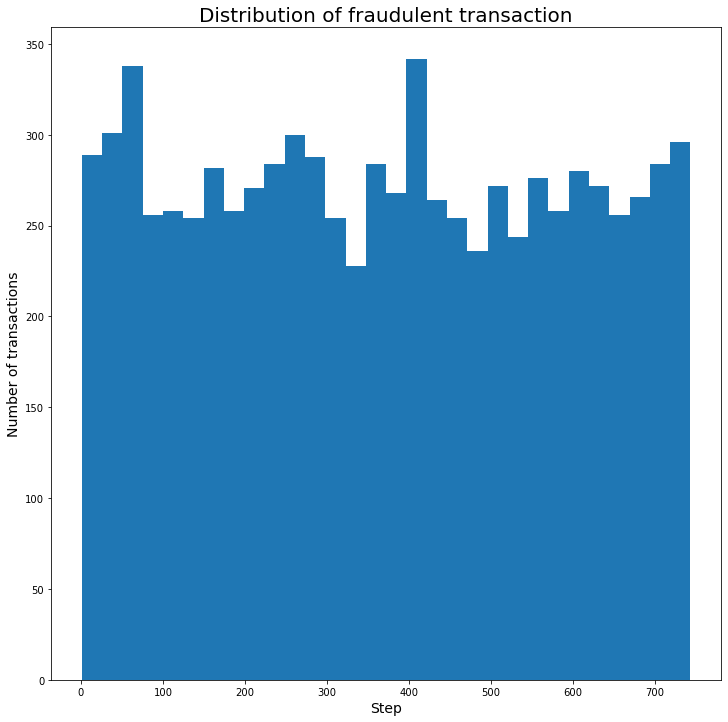

In [23]:
plt.figure(figsize=(12,12))
plt.hist(df[(df['isfraud']==1)].step, bins =30)
plt.xlabel("Step", fontsize = 14)
plt.ylabel("Number of transactions", fontsize = 14)
plt.title("Distribution of fraudulent transaction", fontsize = 20)
plt.show()

**Observation:** The distribution of the fraudulent transactions is fairly equal distributed over time, this feature might not be a good predictor. Also, as we do not know the accurate timing of each step, we will not be able to do further analysis.

### Check on account balances before and after transactions 

Assumption is the difference between the account before and after a transaction should reflect the monetary amount being transferred, paid or cashed out.

In [24]:
#Check on account balance for origin accounts
round((sum(df['old_balance_origin'] - df['amount'] != df['new_balance_origin'])/len(df))*100,2)

85.09

85% of the transactions have erroneous account balance in origin account

In [25]:
#Check on account balance for destination accounts
round((sum(df['old_balance_destination'] + df['amount'] != df['new_balance_destination'])/len(df))*100,2)

74.45

74.5% of the transactions have erroneous account balance in destination account

In [26]:
#Find out the total number transactions with erroneous balance on either origin or destination
error_count = (sum(df['old_balance_origin'] - df['amount'] != df['new_balance_origin']) | 
     sum(df['old_balance_destination'] + df['amount'] != df['new_balance_destination']))

In [27]:
#Find out percentage of transactions with erroneous balance
round((error_count/len(df))*100,2)

93.6

93.6% of the transactions have erroneous account balance in either origin or destination

Next step: Check if there is any negative value in account balances

In [28]:
#Check for number of negative values in "old_balance_origin" field
sum(df['old_balance_origin'] < 0)

0

In [29]:
#Check for number of negative values in "new_balance_origin" field
sum(df['new_balance_origin'] < 0)

0

In [30]:
#Check for number of negative values in "old_balance_destination" field
sum(df['old_balance_destination'] < 0)

0

In [31]:
#Check for number of negative values in "new_balance_destination" field
sum(df['new_balance_destination'] < 0)

0

**Observation:** No negative balances in dataset and high percentage of the records has erroneous account balance after transactions. However, we are unable to determine the root cause of the erroneous account balance thus will not be able to update or replace the value. Would the errorneous account balance has a distinction between fraudulent and valid transactions?   

In [32]:
#Add a new field to df, "balance_origin_error"
df['balance_origin_error'] =  df.amount + df.new_balance_origin - df.old_balance_origin 

In [33]:
#Check the values in the newly created field
df[df['balance_origin_error']>0].head()

,step,type,amount,old_balance_origin,new_balance_origin,old_balance_destination,new_balance_destination,isfraud,balance_origin_error
8,1,PAYMENT,4024.36,2671.0,0.0,0.0,0.00,0,1353.36
10,1,DEBIT,9644.94,4465.0,0.0,10845.0,157982.12,0,5179.94
13,1,PAYMENT,11633.76,10127.0,0.0,0.0,0.00,0,1506.76
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94
16,1,PAYMENT,1563.82,450.0,0.0,0.0,0.00,0,1113.82


In [34]:
#Add a new field to df, "balance_destination_error"
df['balance_destination_error'] =  df.amount + df.old_balance_destination - df.new_balance_destination 

In [35]:
#Check the values in the newly created field
df[df['balance_destination_error']>0].head()

,step,type,amount,old_balance_origin,new_balance_origin,old_balance_destination,new_balance_destination,isfraud,balance_origin_error,balance_destination_error
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14


In [36]:
#Create two new dataframes, one containing valid transactions and the other contains only fraudulent transactions
fraudulent_df = df[(df['isfraud']==1)]
valid_df = df[(df['isfraud']==0)]

In [37]:
#Check the statistics of "balance_origin_error" and "balance_destination_error" field in the fraudulent dataframe
fraudulent_df[['balance_origin_error','balance_destination_error']].describe()

,balance_origin_error,balance_destination_error
count,8.213000e+03,8.213000e+03
mean,1.069233e+04,7.325093e+05
std,2.651461e+05,1.867748e+06
min,-7.450581e-09,-8.875516e+06
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.231460e+03
75%,0.000000e+00,4.427220e+05
max,1.000000e+07,1.000000e+07


In [38]:
#Check the statistics of "balance_origin_error" and "balance_destination_error" field in the valid dataframe
valid_df[['balance_origin_error','balance_destination_error']].describe()

,balance_origin_error,balance_destination_error
count,6.354407e+06,6.354407e+06
mean,2.013386e+05,5.469223e+04
std,6.069289e+05,4.360026e+05
min,-1.000000e-02,-7.588573e+07
25%,3.034305e+03,0.000000e+00
50%,6.904931e+04,3.500680e+03
75%,2.499534e+05,2.925981e+04
max,9.244552e+07,1.319123e+07


**Observation:** For fraudulent transactions, balance_origin_error, 75% of the data is between -7,450,581,000 and 0. Majority of the transactions were 0. As for balance_destination_error, it is quite varied across the records and it is also has similar to valid transactions' balance_destination_error. While for valid transactions, balance_origin_error, huge numbers of records have error. We might be able to use the balance_origin_error feature  for prediction.

##  Prepare the Dataset

In [39]:
#Take a subset of the entire dataset as only TRANSFER and CASH_OUT transactions types have fraudulent transactions
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [40]:
#Since "type" field is of object field type, we will convert it into one-hot encoding
df = pd.get_dummies(df, prefix=['type'], columns = ['type'])

In [41]:
#Check the dataset
df.head()

,step,amount,old_balance_origin,new_balance_origin,old_balance_destination,new_balance_destination,isfraud,balance_origin_error,balance_destination_error,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,0,1


In [42]:
#Save final dataset into csv so that we do not have to iterate through the steps above over again 
df.to_csv('dataset.csv', index=False)

In [49]:
#Load the update dataset into df to check
df = pd.read_csv('dataset.csv')

In [44]:
#Check the 
df.head()

,step,amount,old_balance_origin,new_balance_origin,old_balance_destination,new_balance_destination,isfraud,balance_origin_error,balance_destination_error,type_CASH_OUT,type_TRANSFER
0,1,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,0,1
1,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1,0
2,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1,0
3,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,0,1
4,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,0,1


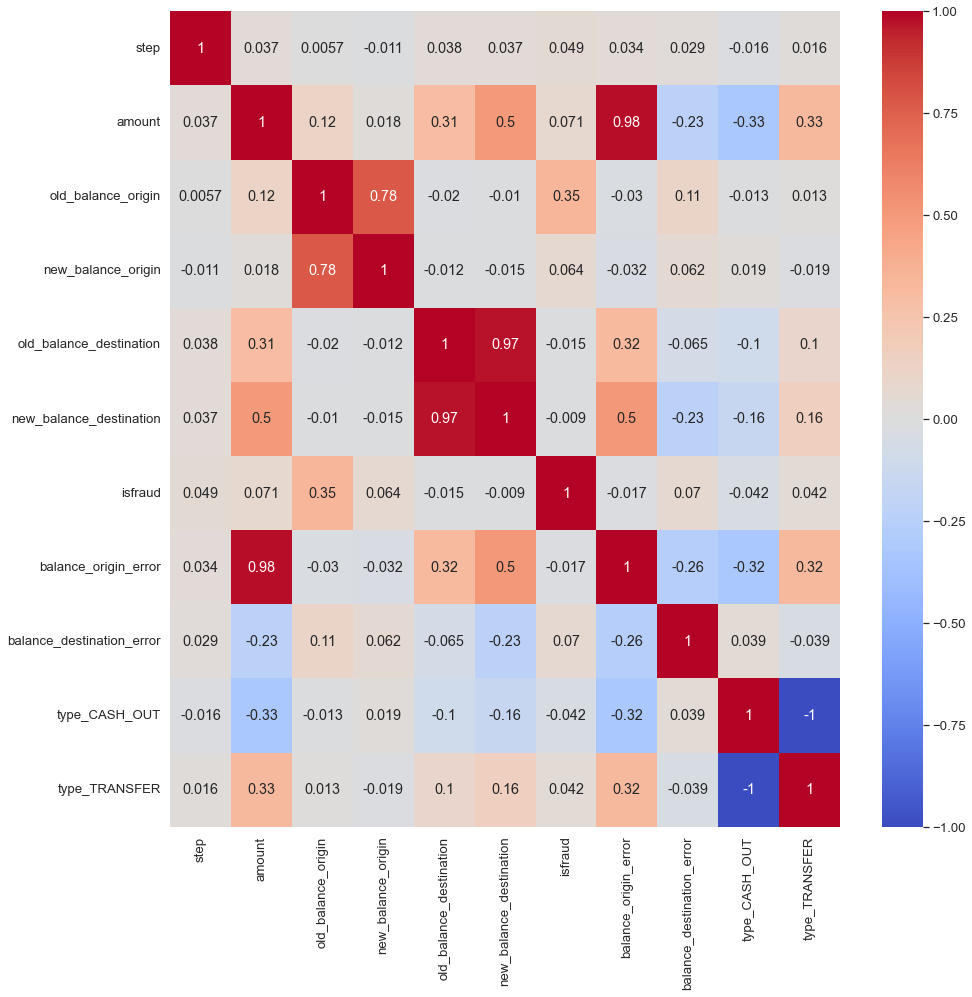

In [50]:
#Plot correlation of fields using heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),cmap = "coolwarm", annot=True)
plt.show()

In [45]:
#Check if the dataset is balanced
df.isfraud.value_counts()

0    2762196
1       8213
Name: isfraud, dtype: int64

In [46]:
#Define target and feature fields
target_col = 'isfraud'
feature_cols = [x for x in df.columns if x != target_col]

y = df[target_col]
X = df[feature_cols]

In [51]:
X.columns

Index(['step', 'amount', 'old_balance_origin', 'new_balance_origin',
       'old_balance_destination', 'new_balance_destination',
       'balance_origin_error', 'balance_destination_error', 'type_CASH_OUT',
       'type_TRANSFER'],
      dtype='object')

In [47]:
#Split the data set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state=1)

In [48]:
#Resample data with SMOTE
counter = Counter(y_train)
print('Before SMOTE',counter)

#Oversampling the train dataset using SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

counter = Counter(y_train_smote)
print('After SMOTE',counter)

Before SMOTE Counter({0: 1933554, 1: 5732})
After SMOTE Counter({0: 1933554, 1: 1933554})


In [49]:
#Resample data with SMOTE + ENN
counter = Counter(y_train)
print('Before SMOTE+ENN',counter)

#Oversampling the train dataset using SMOTE + ENN
smoteenn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smoteenn)
print('After SMOTE+ENN',counter)

Before SMOTE+ENN Counter({0: 1933554, 1: 5732})
After SMOTE+ENN Counter({1: 1929253, 0: 1915255})


In [2]:
import dill

In [66]:
dill.dump_session('notebook_env_after_randomforest.db')

In [9]:
dill.dump_session('notebook_env_after_extratrees.db')

In [3]:
dill.load_session('notebook_env_after_randomforest.db')

In [52]:
best_estimator = {}

In [53]:
#Define function to get best estimator for each machine learning algorithm
def hyperparameter_tuning(X_train, y_train, params, model, algorithm): 
    pipeline = Pipeline(steps = [['scaler', StandardScaler()], [model, algorithm]])
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    grid = GridSearchCV(estimator=pipeline, param_grid=params, scoring='roc_auc', cv = stratified_kfold, n_jobs=-1)
    grid.fit(X_train, y_train)
    if model not in best_estimator:
        best_estimator[model] = grid.best_estimator_.get_params()[model]

In [54]:
model_name = []
precision = []
recall = []
f1score = []
auc_roc = []

In [55]:
def evaluate_model(X_train, y_train, X_test, y_test, model, model_n):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    diff = scores.mean() - model.score(X_test, y_test)
    SD = diff / scores.std()
    y_prob=model.predict_proba(X_test)
    
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(f"Standard Deviations Away: {SD}")
    print(f"Report: {classification_report(y_test, preds)}")
    print(f"Accuracy Score: {accuracy_score(y_test, preds)}")
    
    #Confusion Matrix
    cf_matrix = confusion_matrix(y_test, preds)
    plt.figure(figsize=(16, 10))
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    hm = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    model_name.append(model_n)
    precision.append(precision_score(y_test,preds))
    recall.append(recall_score(y_test,preds))
    f1score.append(f1_score(y_test,preds))
    auc_roc.append(roc_auc_score(y_test, y_prob[:,1]))

## Decision Tree Classifier 

### Decision Tree Classifier - Find best estimator

In [56]:
param_dt = {'DecisionTree__criterion' : ['gini', 'entropy'], 'DecisionTree__max_depth' : [2,4,6,8,10,12]}
hyperparameter_tuning(X_train, y_train, params = param_dt, model = 'DecisionTree', algorithm=DecisionTreeClassifier())

In [57]:
best_estimator['DecisionTree']

DecisionTreeClassifier(criterion='entropy', max_depth=4)

#### Decision Tree with orginal dataset 

Training Score:0.9999871086575162
Cross V Score: 0.9999840147371813 +/- 2.6293181587293343e-06
Testing Score: 0.9999867648952081
Cross & Test Diff: -2.750158026754157e-06
Standard Deviations Away: -1.0459586328963784
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999867648952081


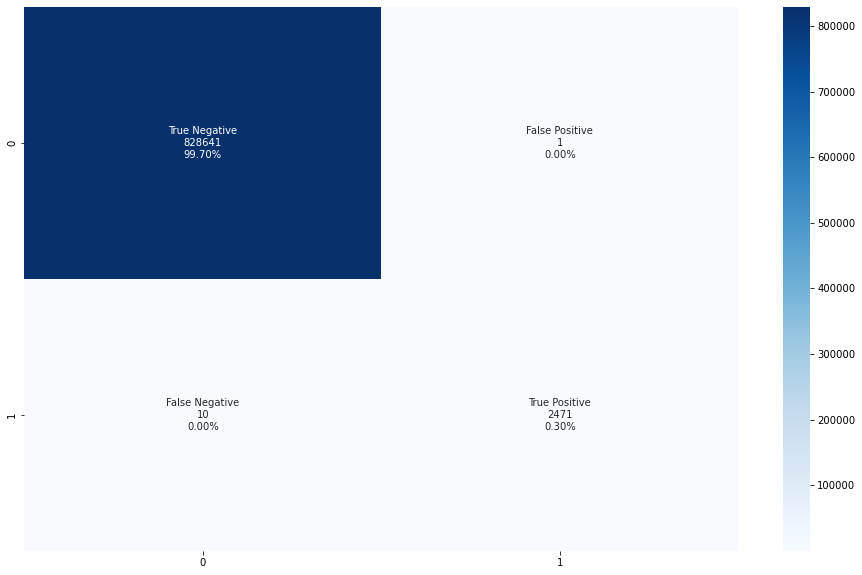

In [58]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
evaluate_model(X_train, y_train, X_test, y_test, model = decision_tree , model_n = 'DecisionTree')

#### Decision Tree with SMOTE dataset

Training Score:0.9977401717252272
Cross V Score: 0.9977368100399575 +/- 1.3896719556351166e-05
Testing Score: 0.9999879680865528
Cross & Test Diff: -0.0022511580465952585
Standard Deviations Away: -161.99204693358155
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999879680865528


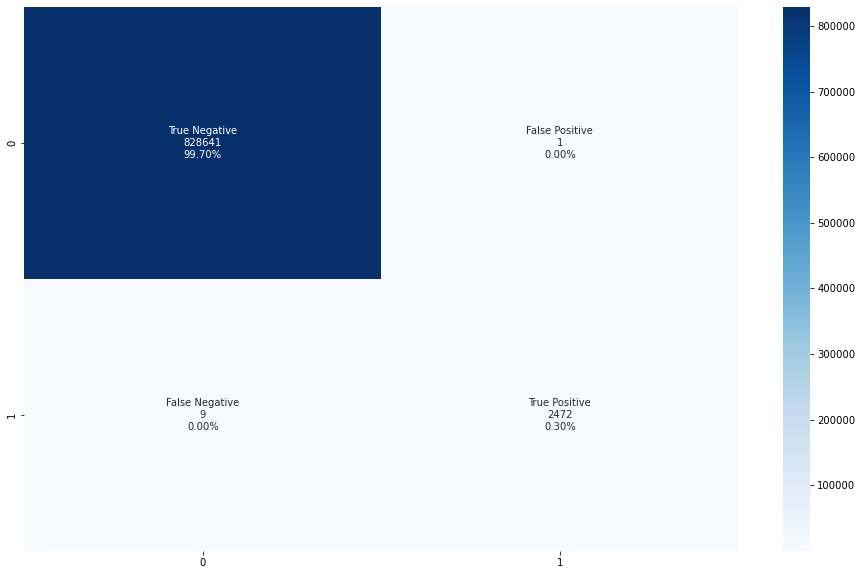

In [59]:
evaluate_model(X_train_smote, y_train_smote, X_test, y_test, model = decision_tree , model_n = 'DecisionTree_SMOTE')

#### Decision Tree with SMOTE+ENN dataset

Training Score:0.9987613499568735
Cross V Score: 0.998751205604811 +/- 3.0405683916302027e-05
Testing Score: 0.9999795457471398
Cross & Test Diff: -0.0012283401423287543
Standard Deviations Away: -40.39837241319801
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999795457471398


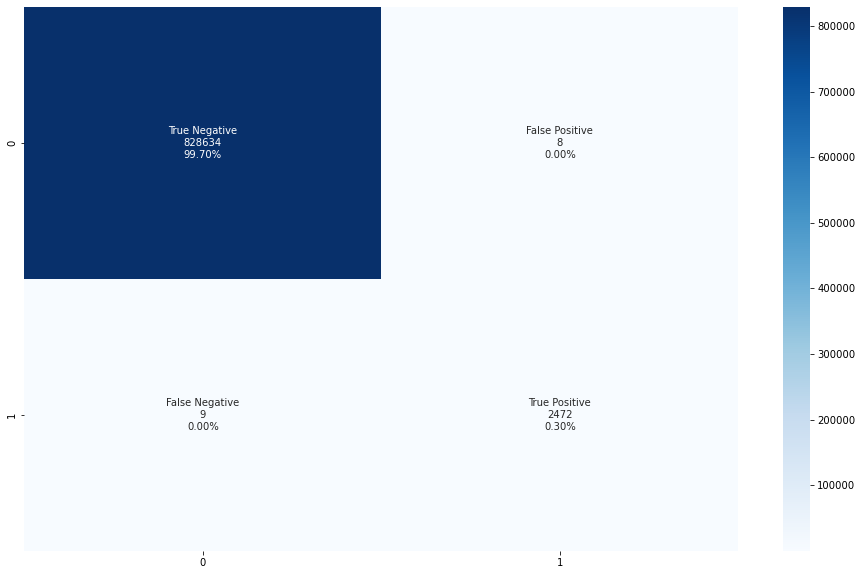

In [60]:
evaluate_model(X_train_smoteenn, y_train_smoteenn, X_test, y_test, model = decision_tree , model_n = 'DecisionTree_SMOTE_ENN')

## Random Forest Classifier 

### Random Forest Classifier - Find best estimator

In [61]:
param_rf = {'RandomForest__max_depth': [3, 5], 'RandomForest__n_estimators': [50, 100]}
hyperparameter_tuning(X_train, y_train, params = param_rf, model = 'RandomForest', algorithm=RandomForestClassifier())

In [62]:
best_estimator['RandomForest']

RandomForestClassifier(max_depth=5)

#### Random Forest Classifier - Original Dataset

Training Score:0.9990341806211152
Cross V Score: 0.999016648399857 +/- 2.417511142334343e-05
Testing Score: 0.9990157894800168
Cross & Test Diff: 8.589198402519926e-07
Standard Deviations Away: 0.03552909540771017
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      0.67      0.80      2481

    accuracy                           1.00    831123
   macro avg       1.00      0.84      0.90    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9990157894800168


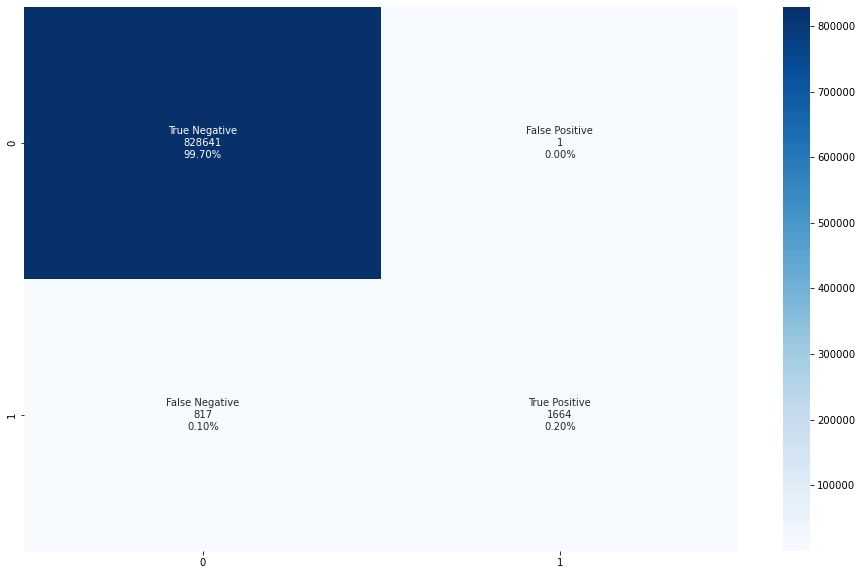

In [63]:
random_forest = RandomForestClassifier(max_depth=5, random_state = 1)
evaluate_model(X_train, y_train, X_test, y_test, model = random_forest , model_n = 'RandomForest')

#### Random Forest Classifier - SMOTE Dataset 

Training Score:0.9978436081950647
Cross V Score: 0.9978402465097949 +/- 1.4895390378437101e-05
Testing Score: 0.999978342555795
Cross & Test Diff: -0.0021380960460001264
Standard Deviations Away: -143.540786221708
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.999978342555795


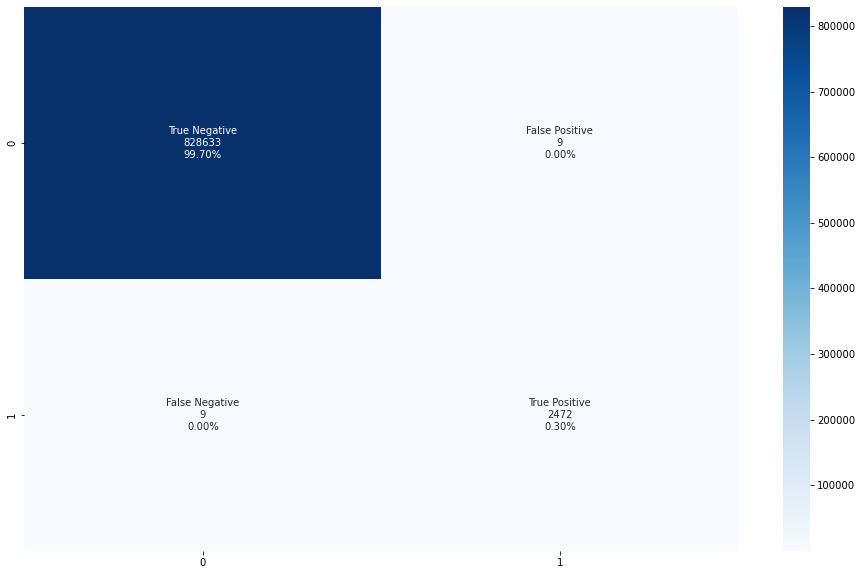

In [64]:
evaluate_model(X_train_smote, y_train_smote, X_test, y_test, model = random_forest , model_n = 'RandomForest_SMOTE')

#### Random Forest Classifier - SMOTE+ENN Dataset 

Training Score:0.9984986375369749
Cross V Score: 0.9984978571949351 +/- 2.487344650144201e-05
Testing Score: 0.9999759361731055
Cross & Test Diff: -0.0014780789781704273
Standard Deviations Away: -59.4239715869185
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999759361731055


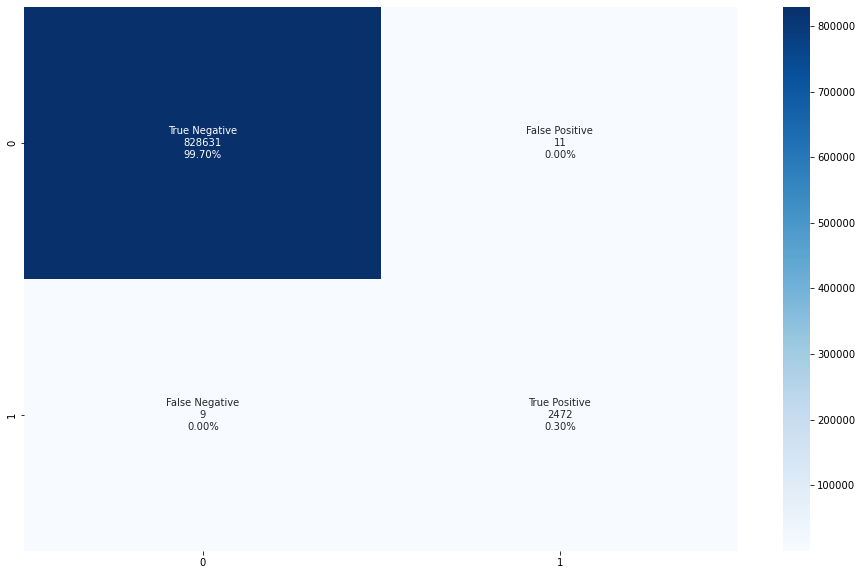

In [65]:
evaluate_model(X_train_smoteenn, y_train_smoteenn, X_test, y_test, model = random_forest , model_n = 'RandomForest_SMOTE_ENN')

## ExtraTrees Classifier

### ExtraTrees Classifier - Find best estimator 

In [4]:
param_et = {'ExtraTrees__criterion': ['gini', 'entropy'], 'ExtraTrees__max_depth': [2,4,6]}
hyperparameter_tuning(X_train, y_train, params = param_et, model = 'ExtraTrees', algorithm=ExtraTreesClassifier(random_state=1))

In [5]:
best_estimator['ExtraTrees']

ExtraTreesClassifier(criterion='entropy', max_depth=6, random_state=1)

#### ExtraTrees Classifier - Original Dataset

Training Score:0.9973294294910601
Cross V Score: 0.9973650096093429 +/- 3.356798604730955e-05
Testing Score: 0.9973216960666472
Cross & Test Diff: 4.331354269571097e-05
Standard Deviations Away: 1.2903229474257518
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      0.10      0.19      2481

    accuracy                           1.00    831123
   macro avg       1.00      0.55      0.59    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9973216960666472


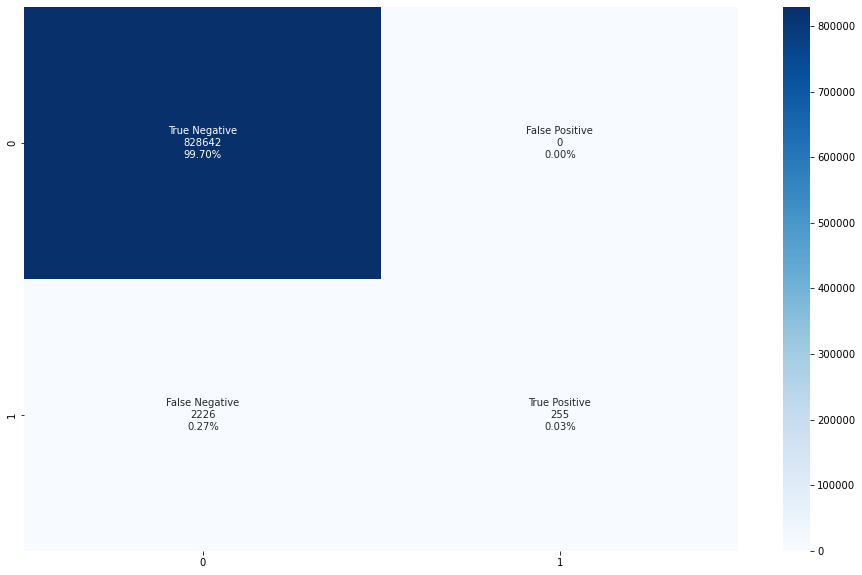

In [6]:
extra_trees = ExtraTreesClassifier(criterion='entropy', max_depth=6, random_state=1)
evaluate_model(X_train, y_train, X_test, y_test, model = extra_trees , model_n = 'ExtraTrees')

#### ExtraTrees Classifier - SMOTE Dataset

Training Score:0.8094627820066055
Cross V Score: 0.8097229247282466 +/- 0.0033022130862876645
Testing Score: 0.8384065896383568
Cross & Test Diff: -0.028683664910110207
Standard Deviations Away: -8.686194427978684
Report:               precision    recall  f1-score   support

           0       1.00      0.84      0.91    828642
           1       0.01      0.79      0.03      2481

    accuracy                           0.84    831123
   macro avg       0.51      0.81      0.47    831123
weighted avg       1.00      0.84      0.91    831123

Accuracy Score: 0.8384065896383568


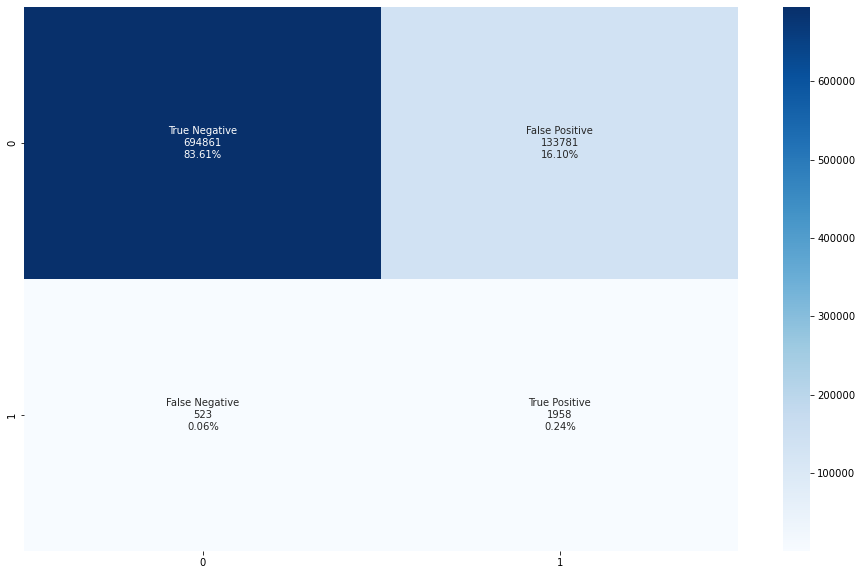

In [7]:
evaluate_model(X_train_smote, y_train_smote, X_test, y_test, model = extra_trees , model_n = 'ExtraTrees_SMOTE')

#### ExtraTrees Classifier - SMOTE+ENN Dataset

Training Score:0.8172595817202097
Cross V Score: 0.8161249771037001 +/- 0.0024734941782869765
Testing Score: 0.8411955871754241
Cross & Test Diff: -0.025070610071723953
Standard Deviations Away: -10.13570611639226
Report:               precision    recall  f1-score   support

           0       1.00      0.84      0.91    828642
           1       0.01      0.80      0.03      2481

    accuracy                           0.84    831123
   macro avg       0.51      0.82      0.47    831123
weighted avg       1.00      0.84      0.91    831123

Accuracy Score: 0.8411955871754241


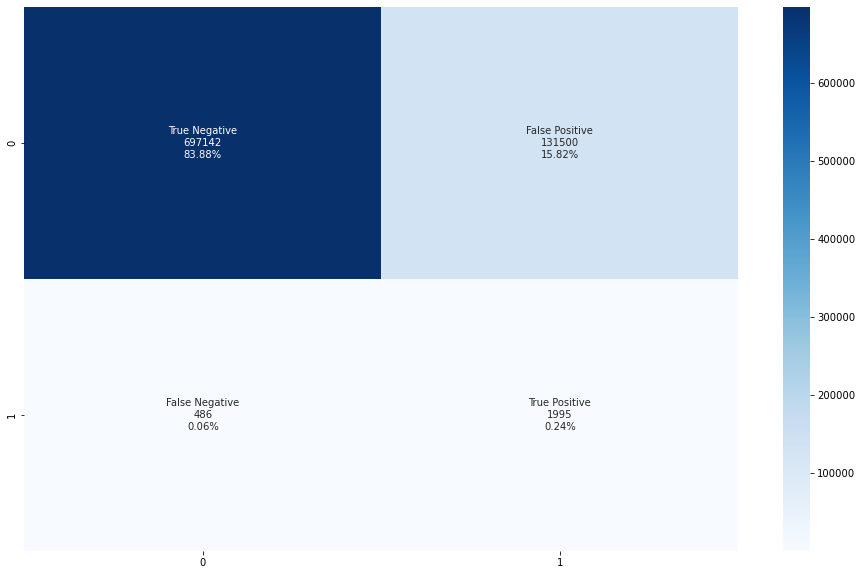

In [8]:
evaluate_model(X_train_smoteenn, y_train_smoteenn, X_test, y_test, model = extra_trees , model_n = 'ExtraTrees_SMOTE_ENN')

## GaussianNB 

#### GaussianNB with Original Dataset

Training Score:0.9874531141873865
Cross V Score: 0.9873242004977066 +/- 0.0007682734805200343
Testing Score: 0.9873652876890665
Cross & Test Diff: -4.10871913598676e-05
Standard Deviations Away: -0.05347990318767246
Report:               precision    recall  f1-score   support

           0       1.00      0.99      0.99    828642
           1       0.10      0.41      0.16      2481

    accuracy                           0.99    831123
   macro avg       0.55      0.70      0.58    831123
weighted avg       1.00      0.99      0.99    831123

Accuracy Score: 0.9873652876890665


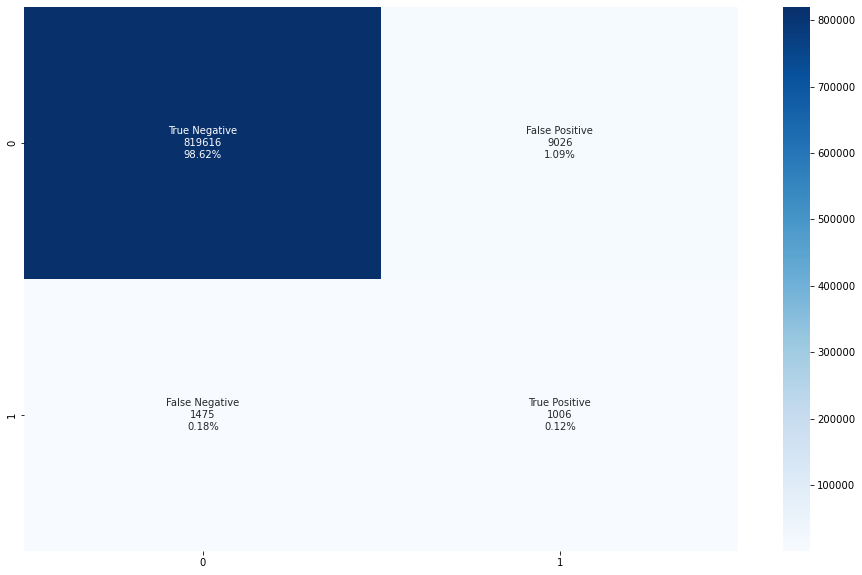

In [33]:
gaussian = GaussianNB()
evaluate_model(X_train, y_train, X_test, y_test, model = gaussian , model_n = 'GaussianNB')

#### GaussianNB with SMOTE Dataset

Training Score:0.7223925476092211
Cross V Score: 0.7224858990232494 +/- 0.0011588663592521514
Testing Score: 0.9798862502902699
Cross & Test Diff: -0.25740035126702043
Standard Deviations Away: -222.1139212576056
Report:               precision    recall  f1-score   support

           0       1.00      0.98      0.99    828642
           1       0.07      0.47      0.12      2481

    accuracy                           0.98    831123
   macro avg       0.53      0.72      0.56    831123
weighted avg       1.00      0.98      0.99    831123

Accuracy Score: 0.9798862502902699


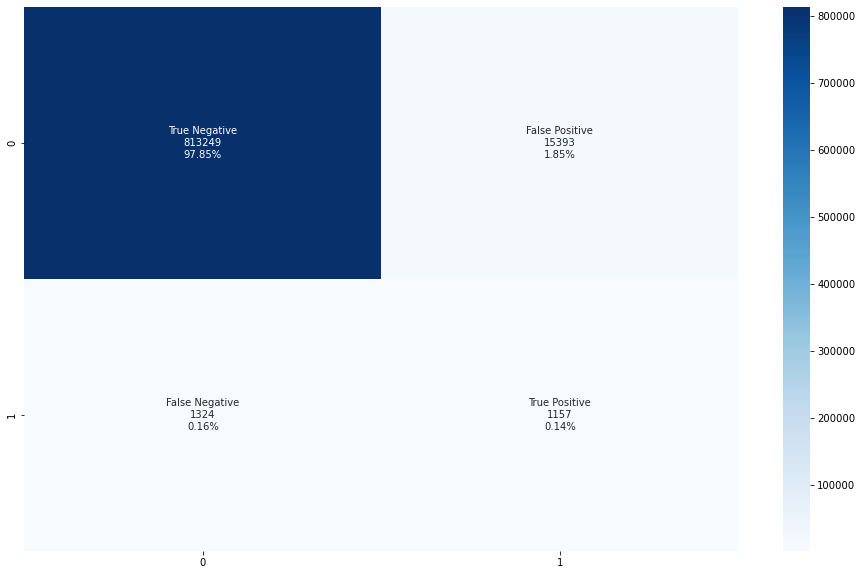

In [34]:
evaluate_model(X_train_smote, y_train_smote, X_test, y_test, model = gaussian , model_n = 'GaussianNB_SMOTE')

#### GaussianNB with SMOTE+ENN Dataset

Training Score:0.7270958988770475
Cross V Score: 0.7271000607604217 +/- 0.0006395066623187993
Testing Score: 0.9779142196762693
Cross & Test Diff: -0.2508141589158477
Standard Deviations Away: -392.19944637701803
Report:               precision    recall  f1-score   support

           0       1.00      0.98      0.99    828642
           1       0.07      0.48      0.11      2481

    accuracy                           0.98    831123
   macro avg       0.53      0.73      0.55    831123
weighted avg       1.00      0.98      0.99    831123

Accuracy Score: 0.9779142196762693


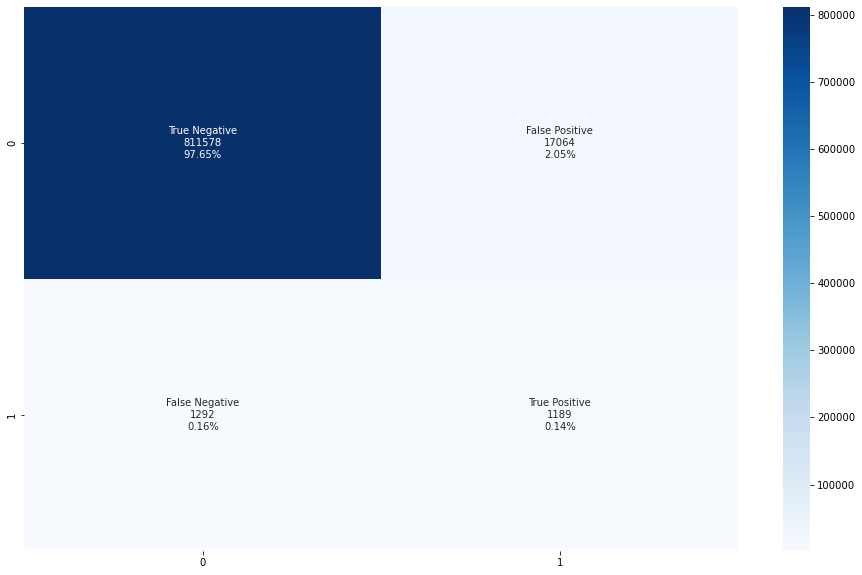

In [35]:
evaluate_model(X_train_smoteenn, y_train_smoteenn, X_test, y_test, model = gaussian , model_n = 'GaussianNB_SMOTE_ENN')

## XGBoost Classifier

In [10]:
#import library
import xgboost as xgb

In [11]:
#Define initial model
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

Define function for xgboost classifer for hyperparameter tuning

In [13]:
def xgboost_model_fit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='auc')
        
    #Predict training set:
    predictions = alg.predict(X_test)
    predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test.values, predictions))
    print ("AUC Score: %f" % metrics.roc_auc_score(y_test, predprob))
    
    plt.figure(figsize=(16, 10))                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar')
    plt.title('Feature Importance', fontsize = '20')
    plt.ylabel('Feature Importance Score', fontsize = '14')

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.9992
AUC Score: 0.998358


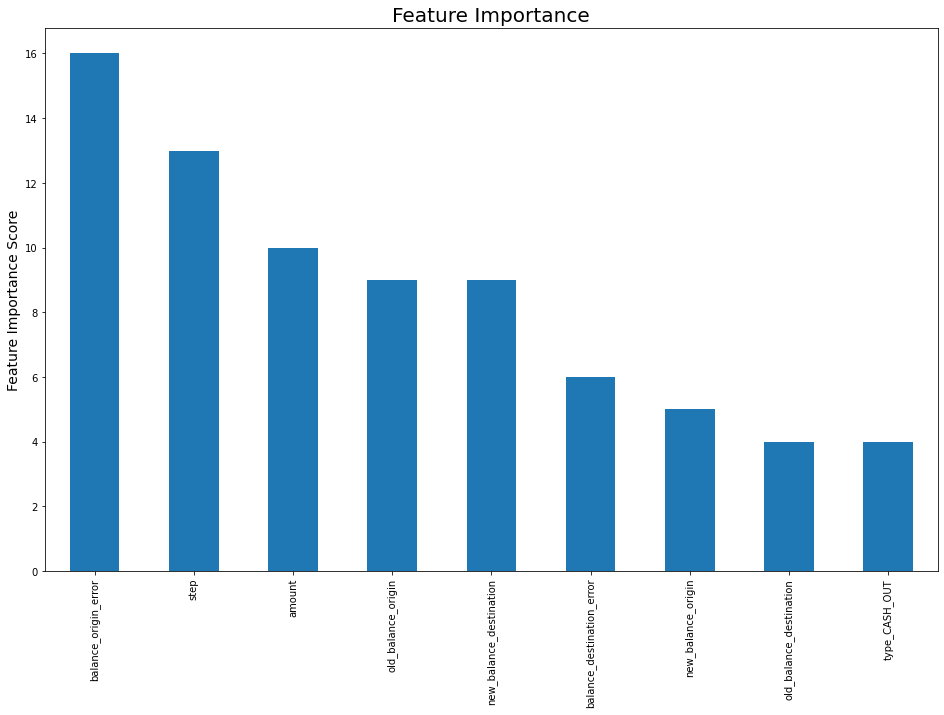

In [14]:
#Fit model into function
xgboost_model_fit(xgb1, X_train, y_train, X_test, y_test)

### XGBoost - Hyperparameter Tuning

In [15]:
#Define parameter set for tuning
xgb_param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

In [16]:
#Use gridsearch to find the best hyperparameter
gridsearch_xgb_1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = xgb_param_test, scoring='roc_auc',n_jobs=4,cv=5)

In [17]:
#Train the model
gridsearch_xgb_1.fit(X_train, y_train)

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [18]:
#Check for the best parameters
gridsearch_xgb_1.best_params_, gridsearch_xgb_1.best_score_

({'max_depth': 9, 'min_child_weight': 3}, 0.9995176967349557)

As we saw earlier, the best parameter for max_depth was 9, we do not know if there are better parameter that are beyond 9. We will do a further check.

In [19]:
#Define parameter set for tuning
xgb_param_test_2 = {
 'max_depth':[9, 11, 13, 15]
}

#Use gridsearch to find the best hyperparameter
gridsearch_xgb_2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = xgb_param_test_2, scoring='roc_auc',n_jobs=4, cv=5)

In [20]:
#Train the model
gridsearch_xgb_2.fit(X_train, y_train)

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_meth

In [21]:
#Check for the best parameters
gridsearch_xgb_2.best_params_, gridsearch_xgb_2.best_score_

({'max_depth': 9}, 0.9995176967349557)

In [22]:
#Define parameter set for tuning - gamma
xgb_param_test_3 = {'gamma':[i/10.0 for i in range(0,5)]
                   }

#Use gridsearch to find the best hyperparameter
gridsearch_xgb_3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = xgb_param_test_3, scoring='roc_auc',n_jobs=4, cv=5)

In [23]:
#Train the model
gridsearch_xgb_3.fit(X_train, y_train)

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:57:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_meth

In [24]:
#Check for the best parameters
gridsearch_xgb_3.best_params_, gridsearch_xgb_3.best_score_

({'gamma': 0.0}, 0.9995176967349557)

In [25]:
#Define model, updated with best parameters
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


Model Report
Accuracy : 1
AUC Score: 0.999535


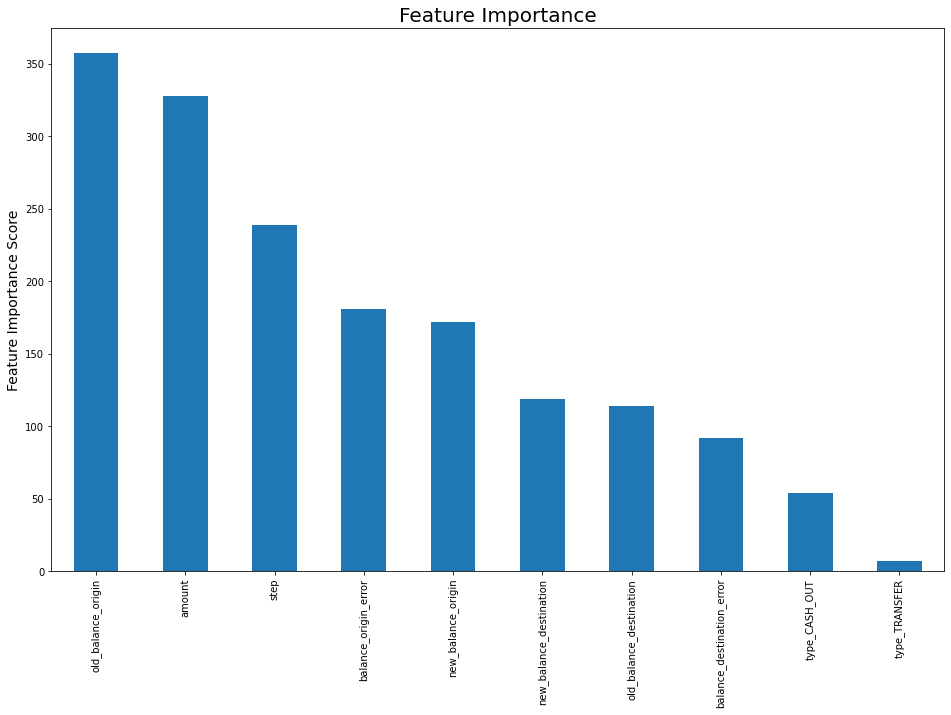

In [26]:
#Check for performance after hyperparameter tuning
xgboost_model_fit(xgb2, X_train, y_train, X_test, y_test)

In [27]:
#Tune subsample and colsample_bytree
xgb_param_test_4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

#Use gridsearch to find the best hyperparameter
gridsearch_xgb_4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = xgb_param_test_4, scoring='roc_auc',n_jobs=4, cv=5)

In [28]:
#Train the model
gridsearch_xgb_4.fit(X_train, y_train)

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:40:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=9, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=177, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.8,
                                     tree_method=

In [29]:
#Check for the best parameters
gridsearch_xgb_4.best_params_, gridsearch_xgb_4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.6}, 0.9994973010455919)

In [30]:
#Dump session so that we do note lose the state of our kernel
dill.dump_session('notebook_env_after_xgboost.db')

[19:00:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:08:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:20:00] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:0.9999922651945097
Cross V Score: 0.9999840147387768 +/- 6.481658202509808e-06
Testing Score: 0.9999891712778975
Cross & Test Diff: -5.156539120698689e-06
Standard Deviations Away: -0.7955586301514618
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       1.00      1.00      1.00      2481

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999891712778975


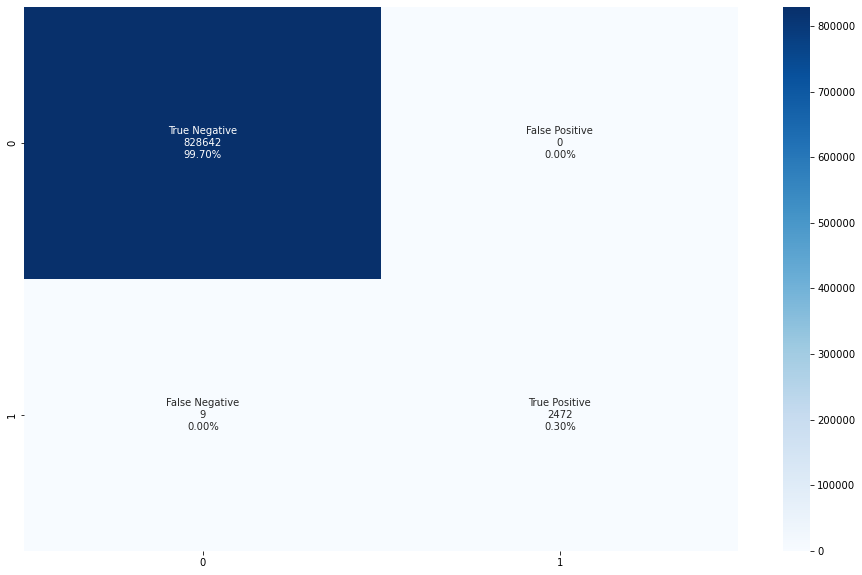

In [31]:
#Define XGBoost classifier with best params
xtreme_gradient_boost = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
evaluate_model(X_train, y_train, X_test, y_test, model = xtreme_gradient_boost , model_n = 'XtremeGradientBoost')

#### XGBoost - SMOTE Dataset

C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:32:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:12:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:49:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\gerra\Anaconda3\envs\Capstone\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:11:58] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Score:0.9999992242264762
Cross V Score: 0.999908975906543 +/- 9.186358213074747e-06
Testing Score: 0.9999302149020061
Cross & Test Diff: -2.1238995463024324e-05
Standard Deviations Away: -2.312014725573766
Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828642
           1       0.98      1.00      0.99      2481

    accuracy                           1.00    831123
   macro avg       0.99      1.00      0.99    831123
weighted avg       1.00      1.00      1.00    831123

Accuracy Score: 0.9999302149020061


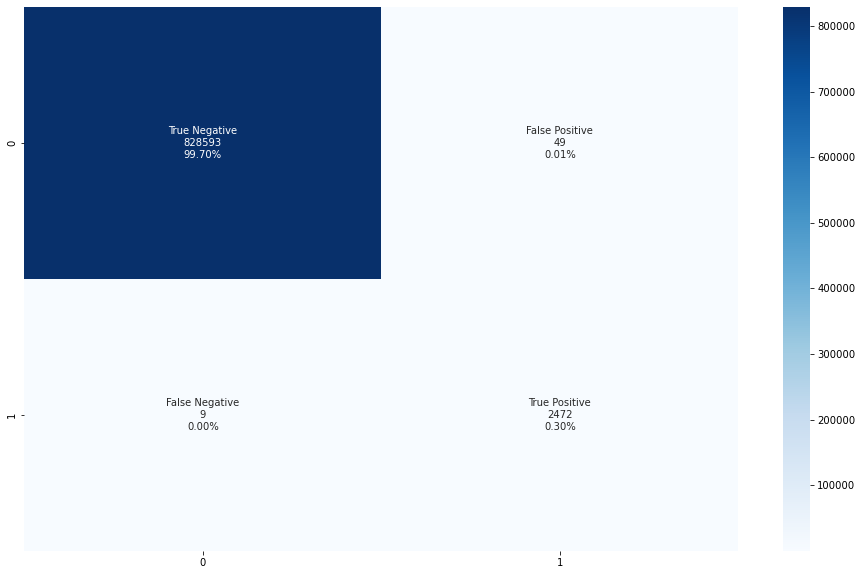

In [32]:
evaluate_model(X_train_smote, y_train_smote, X_test, y_test, model = xtreme_gradient_boost , model_n = 'XtremeGradientBoost_SMOTE')

## Evaluation

In [36]:
evaluation_df = pd.DataFrame({'model':model_name,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':f1score,
                            'AUC-ROC':auc_roc})

In [52]:
evaluation_df.sort_values(by=['f1-score', 'AUC-ROC'], ascending=False)

,model,precision,recall,f1-score,AUC-ROC
9,XtremeGradientBoost,1.000000,0.996372,0.998183,0.999563
1,DecisionTree_SMOTE,0.999596,0.996372,0.997981,0.999336
0,DecisionTree,0.999595,0.995969,0.997779,0.998821
2,DecisionTree_SMOTE_ENN,0.996774,0.996372,0.996573,0.998415
4,RandomForest_SMOTE,0.996372,0.996372,0.996372,0.998835
5,RandomForest_SMOTE_ENN,0.995570,0.996372,0.995971,0.998642
10,XtremeGradientBoost_SMOTE,0.980563,0.996372,0.988405,0.999370
3,RandomForest,0.999399,0.670697,0.802701,0.998919
6,ExtraTrees,1.000000,0.102781,0.186404,0.949269
11,GaussianNB,0.100279,0.405482,0.160793,0.922423
